# 库导入

In [494]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sco
from joblib import Parallel, delayed
import multiprocessing
import datetime
import statsmodels.api as sm
import seaborn
from sklearn.metrics import classification_report
import talib as ta
from collections import OrderedDict #保持Key的顺序
import time
# from WindPy import *
# w.start()

from scipy import stats

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

# pd.set_option('display.height',1000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',1000)

# 数据下载与储存

## 登录聚宽下载数据

In [566]:
import jqdatasdk as jq
jq.auth('13918852005','960312Lsc')

In [567]:
futures_df = jq.get_all_securities(['futures'])

In [569]:
# mainfutures_df = futures_df[(futures_df['display_name'].str.contains('主力合约')) & (~futures_df['display_name'].str.contains('国债'))].copy()
mainfutures_df = futures_df[futures_df['display_name'].str.contains('期货指数')].copy()

In [571]:
mainfutures_CodeName = dict(zip(mainfutures_df.index.tolist(),mainfutures_df.display_name))

In [572]:
mainfutures_list = mainfutures_df.index.tolist()

In [573]:
mainfutures_TradeData_dict = {}
for fu in mainfutures_list:
    mainfutures_TradeData_tmp = jq.get_price(fu, start_date='2005-01-01', end_date='2019-09-06', frequency='daily', fields=['open', 'close', 'low', 'high', 'volume', 'money', 'factor', 'high_limit','low_limit', 'avg', 'open_interest'], skip_paused=False, fq='pre', count=None)
    mainfutures_TradeData_dict[fu] = mainfutures_TradeData_tmp

In [574]:
mainfutures_TradeData_df = pd.DataFrame()
for key in mainfutures_TradeData_dict.keys():
    mainfutures_TradeData_df_tmp = mainfutures_TradeData_dict[key].copy()
    mainfutures_TradeData_df_tmp['class_name'] = mainfutures_CodeName[key]
    mainfutures_TradeData_df_tmp['class'] = key
    mainfutures_TradeData_df = pd.concat([mainfutures_TradeData_df,mainfutures_TradeData_df_tmp],axis=0)

In [575]:
%%time
mainfutures_TradeData_df.to_csv('D:/TrendStrategyData/mainfutures_TradeData.csv')

Wall time: 3.5 s


## 读取本地数据

In [576]:
mainfutures_TradeData_df = pd.read_csv('D:/TrendStrategyData/mainfutures_TradeData.csv',index_col=0)

In [952]:
highV_list = mainfutures_TradeData_df.groupby('class')['money'].mean().sort_values(ascending=False).head(30).index.tolist()
mainfutures_TradeData_df=mainfutures_TradeData_df[mainfutures_TradeData_df['class'].isin(highV_list)].copy()

# 趋势跟踪策略
学术上定义的趋势跟踪，以 Moskowitz et al. (2012) 为代表，用过去 N 个月的收益率符号表示。当过去 N 个月收益为正时，则看多；相反，当过去 N 个月收益为负时，则看空。**收益率符号法常被称为时间序列动量（time series momentum, TSMOM）**，可能是最简单的趋势跟踪规则了，在后来的学术文章中广泛使用。  
Yang, Qian, and Belton (2019) 在讨论趋势跟踪时，介绍了其存在的三宗罪，其中一点是便是对收益率符号的诟病。Yang et al. (2019) 认为，**基于资产过去收益率符号的规则，要么是多头要么是空头，无论何时都会持有仓位，即使没有明显趋势的时候也会持仓，这样就会过度受到噪音的影响，无端带来多余的成本甚至亏损**。  
Baltas and Kosowski (2017) 也讨论过这个问题，他们认为，更精细的交易规则能提升趋势跟踪模型的效果，于是提出了另外一个规则，用收益率的 Newey-West t 统计量作为指标，这样就不会陷入要么 1 要么 -1 的争论。具体来说，对于某个资产，计算其过去 12 个月的日收益率的 Newey-West t 统计量，统计量大于1则为多，统计量小于-1则为空，否则卖空或买多对应的数值。

## 一点想法  - 理论
**上述内容是针对单品种趋势策略的改进，增加了单品种上趋势信号之间的区别，一下想法是在横截面上增强趋势信号之间的区别**
一个均线策略的输出信号是+1、-1形式的，多个均线策略的投票组合信号依然是离散的，且在不同资产中的均线信号缺乏可比性，无法通过均线信号进行类似因子分组的研究  
将**不可比较的离散均线策略信号**转化为**可比较的离散均线策略信号**后可以对不同资产释放出的均线信号进行横截面上筛选  
**转化方式**  
$$ r_{t,i}=\beta_{t,0}+\sum_{j}\beta_{t,j}MAsignal_{t-1,i,n_j}+\epsilon_t $$
$$ \tilde{\beta}_{t,j}=\frac{1}{N}\sum_{k=0}^{N-1}\hat{\beta}_{t-k,j}\omega_k $$
PS：特点在于对多均线策略的{+1，-1，...}信号组合附加了可比值$\hat{r}_{t,i}$

## 一点想法  - 实践
$\hat{r}_{t,i}$类似因子，可对资产进行分组，是一种应用于多品种期货的均线策略

### 均线因子计算 - 策略频率可选

In [953]:
how = 'W'

In [954]:
# 转化为月度数据
mainfutures_TradeData_df_ = mainfutures_TradeData_df.copy()
mainfutures_TradeData_df_.index = pd.to_datetime(mainfutures_TradeData_df_.index)
mainfutures_TradeData_df_['date'] = mainfutures_TradeData_df_.index
def Resample(df):
    df_=df.copy().sort_values('date')
    return df_.apply(lambda x: x.resample(how).last()).reset_index(drop=True)
mainfutures_TradeData_df_M = mainfutures_TradeData_df_.groupby('class').apply(Resample).reset_index(drop=True)

In [955]:
# 日度行情数据，添加日期列，数据格式时间
mainfutures_TradeData = mainfutures_TradeData_df.copy()
mainfutures_TradeData.index = pd.to_datetime(mainfutures_TradeData.index)
mainfutures_TradeData['date'] = mainfutures_TradeData.index
mainfutures_TradeData=mainfutures_TradeData.reset_index(drop=True)
mainfutures_TradeData = mainfutures_TradeData.set_index(['class_name','class','date']).dropna(how='all').reset_index()

In [956]:
# 获取月度交易日
mainfutures_TradeM = sorted(mainfutures_TradeData_df_M['date'].unique())

In [957]:
# 均线信号设定
MA_list = [[1,20],[1,60],[1,120],[5,20],[5,60],[5,120],]
MA_namelist = []
for shortW,longW in MA_list:
        MA_namelist.append('S%dL%d'%(shortW,longW))

In [959]:
# 日度数据计算月度因子
# 计算月度均线信号
def MAsignal(df,shortW,longW):
    df_=df.copy()
    signal_tmp = (df_['close'][-shortW:].mean()-df_['close'][-longW:].mean())
    if signal_tmp>0:
        return 1
    elif signal_tmp<0:
        return -1
    else:
        return signal_tmp
def ComputeMfactor(df):
    df_=df.copy().sort_values('date')
    save_dict = {}
    save_dict['class'] = [df_['class'].tolist()[0]]
    for shortW,longW in MA_list:
        save_dict['S%dL%d'%(shortW,longW)] = [MAsignal(df_,shortW,longW)]
    return pd.DataFrame(save_dict)
mainfutures_M_Allsignal = pd.DataFrame()
if how=='M':
    startN = 6
elif how=='W':
    startN = 24
for MdateCnt in range(startN,len(mainfutures_TradeM)):
    Mdate = mainfutures_TradeM[MdateCnt]
    Last_Mdate = mainfutures_TradeM[MdateCnt-startN]
    mainfutures_M = mainfutures_TradeData[(mainfutures_TradeData['date']>=Last_Mdate) & (mainfutures_TradeData['date']<=Mdate)].copy()
    mainfutures_M_signal = mainfutures_M.groupby('class').apply(ComputeMfactor).reset_index(drop=True)
    mainfutures_M_signal['date'] = Mdate
    mainfutures_M_Allsignal = pd.concat([mainfutures_M_Allsignal,mainfutures_M_signal],axis=0,sort=True)

In [960]:
mainfutures_Factor = mainfutures_TradeData_df_M.merge(mainfutures_M_Allsignal,on=['date','class'],how='left').dropna()

In [961]:
# 计算期货下个月收益，用以横截面回归
def ComputeNextRet(df):
    df_=df.copy().sort_values('date')
    df_['next_ret']=(df_['close']/df_['close'].shift(1)-1).shift(-1)
    return df_
mainfutures_Factor_V0 = mainfutures_Factor.groupby('class').apply(ComputeNextRet).reset_index(drop=True)

In [962]:
# 横截面回归得到回归系数
def CrossSReg(df):
    df_=df.copy()
    X = df_[MA_namelist].copy()
    X_c = sm.add_constant(X)
    y = df_[['next_ret']]
    result = sm.OLS(y,X_c).fit()
    return result.params.to_frame().T
mainfutures_Factor_params = mainfutures_Factor_V0.groupby('date').apply(CrossSReg)
mainfutures_Factor_params.index = mainfutures_Factor_params.index.droplevel(1)
mainfutures_Factor_params = mainfutures_Factor_params.reset_index()

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [963]:
# 回归系数平滑处理，延后一起确保不引入未来数据
if how=='M':
    startW = 12
elif how=='W':
    startW = 36
mainfutures_Factor_paramsR = mainfutures_Factor_params.set_index('date').rolling(startW,min_periods=1).mean().shift(1)

In [964]:
# 根据回归系数代入各观测信号得到预测下期收益率
def GetNextRetHat(df):
    df_=df[['class','date']+MA_namelist].copy()
    mainfutures_Factor_paramsR_sub = mainfutures_Factor_paramsR[mainfutures_Factor_paramsR.index==df_['date'].tolist()[0]].copy()
    df_0=df_.set_index(['class','date']).mul(mainfutures_Factor_paramsR_sub,axis=1)
    df_0['const']=mainfutures_Factor_paramsR_sub['const'].tolist()[0]
    df_1=df_0.sum(axis=1).to_frame('next_ret_hat').reset_index()
    return df_1
mainfutures_Factor_V1 = mainfutures_Factor_V0.groupby('date').apply(GetNextRetHat).reset_index(drop=True)

In [965]:
# 所有数据合并
mainfutures_Factor_V3 = mainfutures_Factor_V0.merge(mainfutures_Factor_V1,on=['class','date'],how='left')
start='2006-01-01'
end='2019-08-31'
mainfutures_Factor_V3 = mainfutures_Factor_V3[(mainfutures_Factor_V3['date']>=start) & (mainfutures_Factor_V3['date']<=end)].copy()

### 因子分组，绘制净值曲线

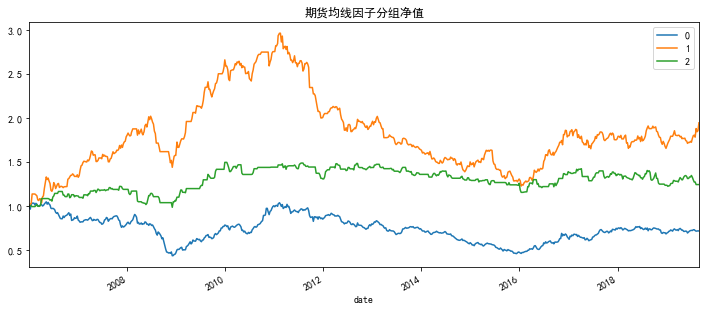

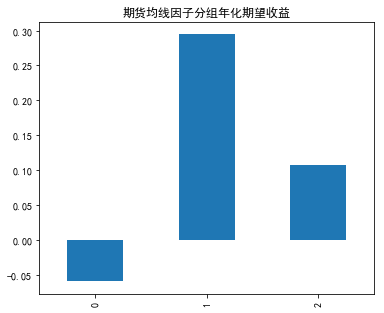

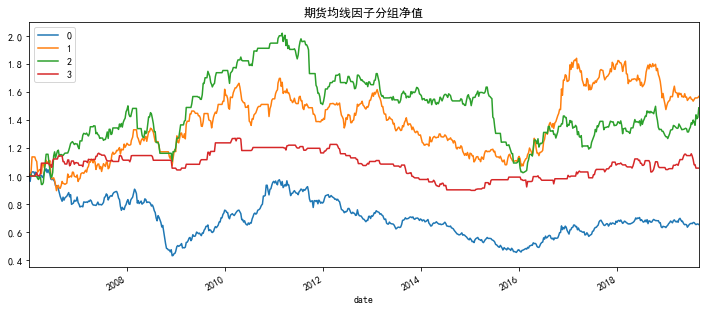

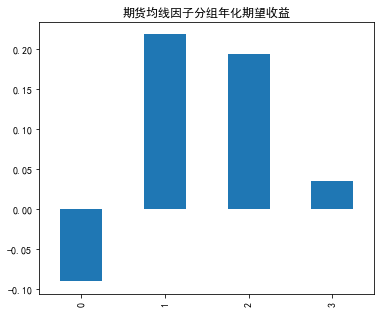

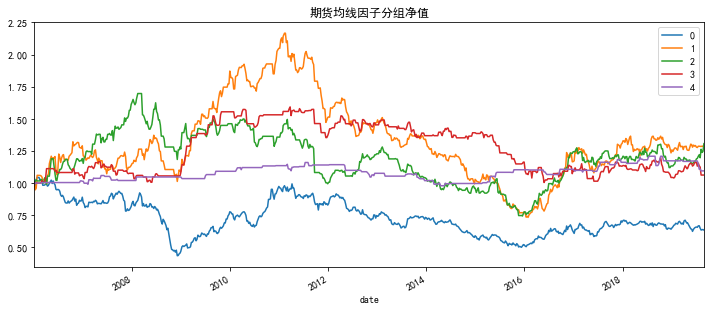

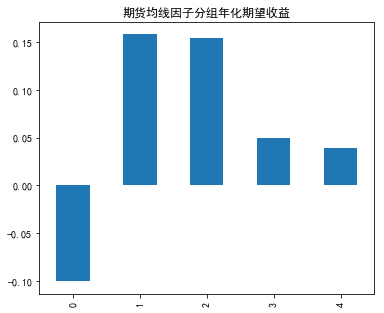

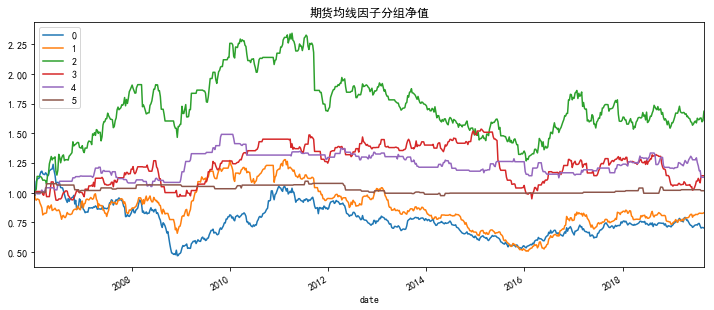

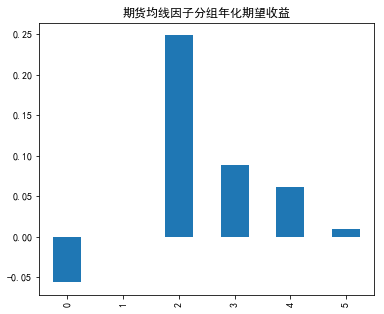

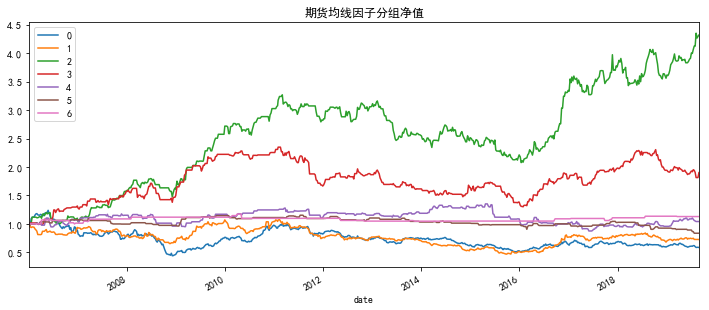

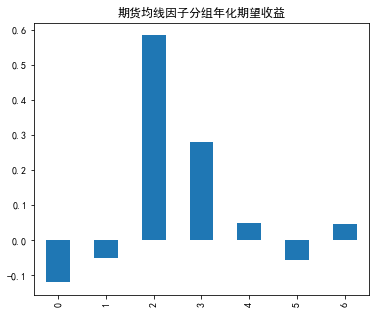

In [966]:
# 根据因子，横截面上分组 - 函数
def Qcut(df,Qn=5):
    df_=df.copy()
    df_['group'] = pd.qcut(df_['next_ret_hat'],Qn,duplicates='drop',labels=False)
    return df_
# 计算分组收益 - 函数
def ComputeRet(df):
    df_=df.copy()
    df_ = df_[df_['group']==group_num].copy()
    return df_['next_ret'].mean()

for Qn in [3,4,5,6,7]:
    # 根据因子，横截面上分组
    mainfutures_Factor_V4=mainfutures_Factor_V3.groupby('date').apply(Qcut,Qn=Qn).reset_index(drop=True)
    # 计算分组收益
    mainfutures_Factor_V5 = pd.DataFrame()
    for group_num in range(Qn):
        mainfutures_Factor_V5=pd.concat([mainfutures_Factor_V5,mainfutures_Factor_V4.groupby('date').apply(ComputeRet).to_frame(group_num)],axis=1)
    mainfutures_Factor_V5=(mainfutures_Factor_V5.shift(1).fillna(0)+1).cumprod()
    # 结果展示
    # mainfutures_Factor_V5['re']=mainfutures_Factor_V5[mainfutures_Factor_V5.columns[-1]]/mainfutures_Factor_V5[0]
    mainfutures_Factor_V5.plot(figsize=(12,5),title='期货均线因子分组净值')
    plt.show()
    (mainfutures_Factor_V5.pct_change().mean()*252).plot.bar(figsize=(6,5),title='期货均线因子分组年化期望收益')
    plt.show()

月度策略的分组效果较差，多空对冲结果也较差，每月调整的均线因子用以预测下一个月收益较难，这一结果是复合逻辑与预期的，均线系统于每月末得到的信号仅适用于短期趋势预测。  
将月度策略转换为周度后，预测窗口变短，模型与信号更迭变快，预测效果变好 - 周度分组后的所有结果普遍优于月度分组后的所有结果。  
但周度策略得到的均线因子分组收益并不单调，一个异象是因子的中间组收益表现较好：因子本身数值是使用均线信号预测的未来收益，中间组是预测值较为接近0的组，其含义是根据历史观测结果，本期的均线信号组合属于不具有明显预测效果（不好也不差）一类，结果却能够取得较好收益。

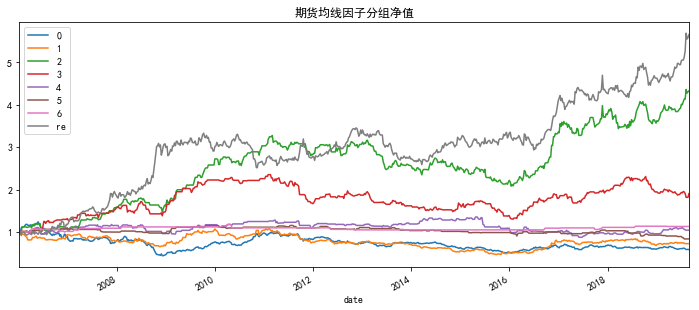

In [967]:
# 结果展示
mean_series = (mainfutures_Factor_V5.pct_change().mean()*252)
winner = mean_series.idxmax()
loser = mean_series.idxmin()
mainfutures_Factor_V5_tmp=mainfutures_Factor_V5.pct_change()
mainfutures_Factor_V5_tmp['re']=mainfutures_Factor_V5_tmp[winner]-mainfutures_Factor_V5_tmp[loser]
mainfutures_Factor_V5['re']=(mainfutures_Factor_V5_tmp.fillna(0)+1).cumprod()['re']
mainfutures_Factor_V5.plot(figsize=(12,5),title='期货均线因子分组净值')
plt.show()

将表现最好的组与表现最差的组进行净值对比后可以得到具有一定强度的曲线，在2016年以后该多空对冲净值曲线呈现快速上升趋势  
**（结果对beta系数平滑窗口较为敏感，不是一个普遍成立的结论）**

## 收益率持续性检验

In [968]:
# 转化为月度数据
mainfutures_TradeData_df_ = mainfutures_TradeData_df.copy()
mainfutures_TradeData_df_.index = pd.to_datetime(mainfutures_TradeData_df_.index)
mainfutures_TradeData_df_['date'] = mainfutures_TradeData_df_.index
def Resample(df):
    df_=df.copy().sort_values('date')
    return df_.apply(lambda x: x.resample('M').last()).reset_index(drop=True)
mainfutures_TradeData_df_M = mainfutures_TradeData_df_.groupby('class').apply(Resample).reset_index(drop=True)

In [969]:
# 期货代码与中文对照字典
mainfutures_name=mainfutures_TradeData_df_M.groupby('class').last().reset_index()
mainfutures_nameD=dict(zip(mainfutures_name['class'],mainfutures_name['class_name'].apply(lambda x: x.replace('期货指数',''))))
mainfutures_nameDD=dict(zip(mainfutures_name['class_name'].apply(lambda x: x.replace('期货指数','')),mainfutures_name['class']))

In [970]:
# 日度行情数据，添加日期列，数据格式时间
mainfutures_TradeData = mainfutures_TradeData_df.copy()
mainfutures_TradeData.index = pd.to_datetime(mainfutures_TradeData.index)
mainfutures_TradeData['date'] = mainfutures_TradeData.index
mainfutures_TradeData=mainfutures_TradeData.reset_index(drop=True)
mainfutures_TradeData = mainfutures_TradeData.set_index(['class_name','class','date']).dropna(how='all').reset_index()

In [971]:
# 获取月度交易日
mainfutures_TradeM = pd.to_datetime(sorted(mainfutures_TradeData_df_M['date'].unique()))

In [972]:
# 日度数据计算月度因子
# 计算月度已实现波动 - 等权标准差 OR 指数加权
def ComputeRVol(df,hisW=63):
    df_=df.copy().sort_values('date')
    df_['ret'] = df_['close']/df_['close'].shift(1)-1
#     sigma = df_['ret'][-hisW:].std()*(252**0.5)
    sigma = df_['ret'][-hisW:].ewm(span=63,adjust=False,min_periods=63).std().tolist()[-1]*(252**0.5)
    return pd.DataFrame([sigma],columns=['sigmaY'])

mainfutures_M_Allsigma = pd.DataFrame()
for MdateCnt in range(4,len(mainfutures_TradeM)):
    Mdate = mainfutures_TradeM[MdateCnt]
    Last_Mdate = mainfutures_TradeM[MdateCnt-4]
    mainfutures_M = mainfutures_TradeData[(mainfutures_TradeData['date']>=Last_Mdate) & (mainfutures_TradeData['date']<=Mdate)].copy()
    mainfutures_M_sigma = mainfutures_M.groupby('class').apply(ComputeRVol,hisW=63)
    mainfutures_M_sigma.index=mainfutures_M_sigma.index.droplevel(1)
    mainfutures_M_sigma=mainfutures_M_sigma.reset_index(drop=False)
    mainfutures_M_sigma['date'] = Mdate
    mainfutures_M_Allsigma = pd.concat([mainfutures_M_Allsigma,mainfutures_M_sigma],axis=0,sort=True)

In [973]:
# 计算期货月收益
def ComputeRet(df):
    df_=df.copy().sort_values('date')
    df_['ret_mY']=(df_['close']/df_['close'].shift(1)-1)*12
    return df_
mainfutures_ret = mainfutures_TradeData_df_M.groupby('class').apply(ComputeRet).reset_index(drop=True)

In [974]:
# 计算风险调整收益
mainfutures_ForContinue = mainfutures_ret.merge(mainfutures_M_Allsigma,on=['date','class'],how='left').dropna()
mainfutures_ForContinue['ret_sigma'] = mainfutures_ForContinue['ret_mY']/mainfutures_ForContinue['sigmaY']

In [975]:
# 对风险调整收益进行盖帽处理，避免outliner过度影响回归结果
def extreme_process_MAD(data,num=3):#data为输入的数据集，如果数值超过num个判断标准则使其等于num个标准
    data_=data.copy()  # 为不破坏原始数据，先对其进行拷贝
    NotNumList = ['class','date']
    feature_names = [i for i in data_.columns.tolist() if i not in NotNumList]   #获取数据集中需测试的因子名
    median=data_[feature_names].median(axis=0)  #获取中位数
    MAD=abs(data_[feature_names].sub(median,axis=1)).median(axis=0) #按列索引匹配，并在行中广播
    data_.loc[:,feature_names]=data_.loc[:,feature_names].clip(lower=median-num*1.4826*MAD,upper=median+num*1.4826*MAD,axis=1) #利用clip()函数，将因子取值限定在上下限范围内，即用上下限来代替异常值
    return data_
mainfutures_ForContinue_exOut = extreme_process_MAD(mainfutures_ForContinue[['class','date','ret_sigma']].copy())
# mainfutures_ForContinue_exOut = mainfutures_ForContinue[['class','date','ret_sigma']].copy()

In [976]:
def lagfun(df,lag):
    df_=df.copy().sort_values('date')
    df_['ret_sigma_lag%d'%(lag)]=df_['ret_sigma'].shift(lag)
    return df_
lag_list = []
tvalues_list = []
for lag in range(1,61):
    tvalues_list_sub=[]
    kind_list=[]
    mainfutures_ForContinue_exOutV0 = mainfutures_ForContinue_exOut.groupby('class').apply(lagfun,lag=lag).reset_index(drop=True).dropna()
    # 全期货混合回归
    X=mainfutures_ForContinue_exOutV0[['ret_sigma_lag%d'%(lag)]]
    y=mainfutures_ForContinue_exOutV0[['ret_sigma']]
    X_c=sm.add_constant(X)
    lag_list.append(lag)
    tvalues_list_sub.append(sm.OLS(y,X_c).fit().tvalues['ret_sigma_lag%d'%(lag)])
    kind_list.append('ALL')
#     # 单个期货回归
#     for kind in futureList:
#         mainfutures_ForContinue_exOutV0_sub=mainfutures_ForContinue_exOutV0[mainfutures_ForContinue_exOutV0['class']==kind].copy()
#         X=mainfutures_ForContinue_exOutV0_sub[['ret_sigma_lag%d'%(lag)]]
#         y=mainfutures_ForContinue_exOutV0_sub[['ret_sigma']]
#         X_c=sm.add_constant(X)
#         tvalues_list_sub.append(sm.OLS(y,X_c).fit().tvalues['ret_sigma_lag%d'%(lag)])
#         kind_list.append(kind)
    tvalues_list.append(tvalues_list_sub)
retContinueDf = pd.DataFrame(dict(zip(lag_list,tvalues_list)))
retContinueDf.index=kind_list

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp in

F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)
F:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2389: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp in

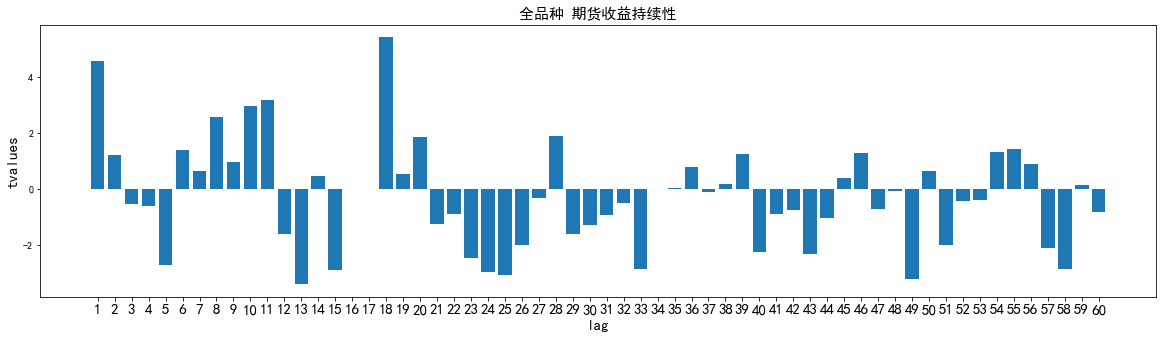

In [977]:
# 收益持续性 - 自回归滞后阶数与t统计量条形图
retContinueDfAll = retContinueDf.T
mainfutures_nameD['ALL'] = '全品种'
for col in retContinueDfAll.columns:
    retContinueDf_sub = retContinueDfAll[[col]].copy()
    plt.figure(figsize=(20,5))
    plt.bar(retContinueDf_sub.index,retContinueDf_sub[col])
    plt.xlabel('lag',fontsize=15)
    plt.ylabel('tvalues',fontsize=15)
    plt.title('%s 期货收益持续性'%(mainfutures_nameD[col]),fontsize=15)
    plt.xticks(retContinueDf.T.index,rotation=0,fontsize=15)
    plt.show()

整体呈现一定的收益持续性，各品种之间的收益持续性区别较大，可分版块研究收益持续性特点，考虑将主力合约替换为指数，加入债券数据！  
改用指数数据后（非主力合约数据）收益持续性与预期较为相近，在一年内（12个月）大部分滞后阶数对应的回归系数t统计量均为正，收益具有持续性。

## 各品种历史表现分析

In [978]:
def Performance(df):
    df_=df.dropna().copy()
    cum_ret=df_['close'][-1]/df_['close'][0]-1
    start_day=df_['date'][0]
    end_day=df_['date'][-1]
    last=(end_day-start_day).days
    annual_ret=(cum_ret+1)**(365.25/last)-1
    annual_vol=df_['close'].pct_change().dropna().std()*(252**0.5)
    IR=annual_ret/annual_vol
    return pd.DataFrame({'年化收益':[annual_ret],'年化波动':[annual_vol],'IR':[IR],})
mainfutures_perf = mainfutures_TradeData_df_.groupby('class').apply(Performance)
mainfutures_perf.index=mainfutures_perf.index.droplevel(1)
# mainfutures_perf=mainfutures_perf.reset_index()

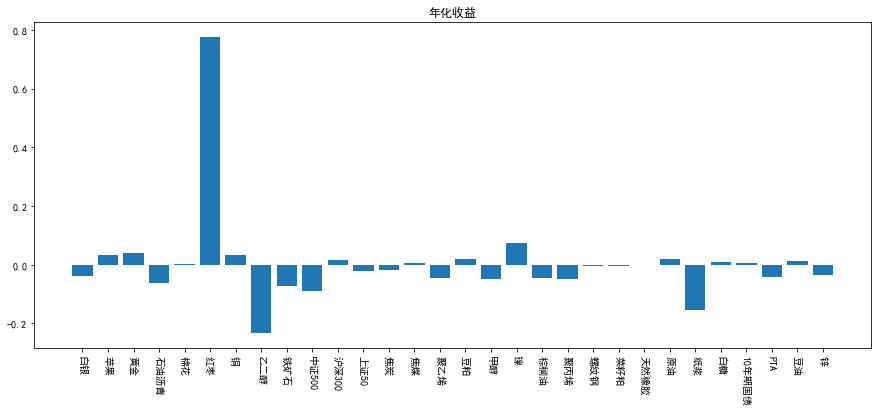

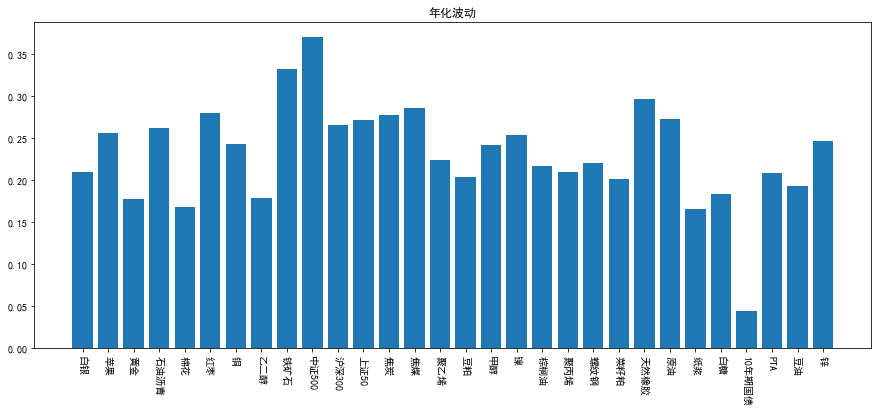

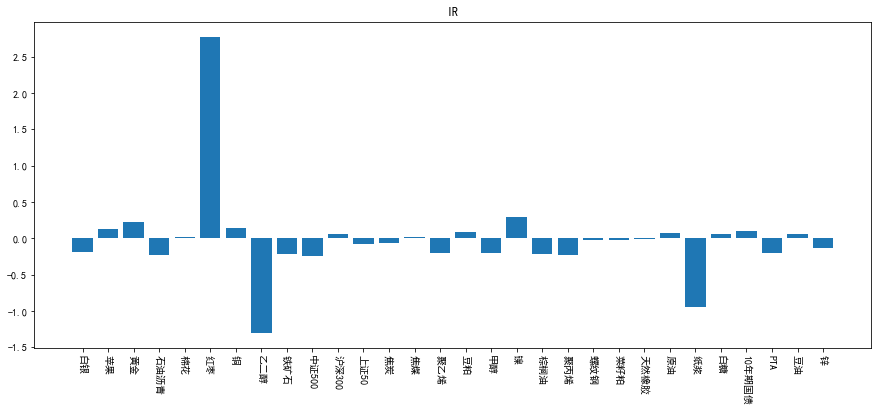

In [980]:
# mainfutures_perf_plt = mainfutures_perf[~mainfutures_perf.index.isin([mainfutures_nameDD['红枣'],mainfutures_nameDD['20号胶'],mainfutures_nameDD['尿素']])].copy()
mainfutures_perf_plt = mainfutures_perf.copy()
for col in mainfutures_perf_plt.columns:
    plt.figure(figsize=(15,6))
    plt.bar([mainfutures_nameD[name] for name in mainfutures_perf_plt.index] ,mainfutures_perf_plt[col])
    plt.xticks(rotation=-90)
    plt.title(col)
    plt.show()

## 各品种趋势跟踪策略表现分析

In [981]:
# 日度数据计算月度因子
# 计算月度动量与波动因子 - 等权标准差 OR 指数加权
def ComputeMom(df,hisW_list):
    df_=df.copy().sort_values('date')
    df_=df_.fillna(method='ffill')
    if len(df_)<hisW_list[-1]:
        return pd.DataFrame()
    df_['ret'] = df_['close']/df_['close'].shift(1)-1
    ## 计算波动
#     sigma = df_['ret'][-hisW:].std()*(252**0.5)
    sigma_list = []
    for hisW in hisW_list:
        sigma = df_['ret'][-hisW:].ewm(span=hisW,adjust=False,min_periods=hisW).std().tolist()[-1]*(252**0.5)
        if sigma == 0:
            return pd.DataFrame()
        sigma_list.append(sigma)
    sigma_df = pd.DataFrame(sigma_list,index=['sigmaY%d'%(hisW) for hisW in hisW_list]).T
    ## 计算动量
    mom_list = []
    for hisW in hisW_list:
        mom = df_['close'].tolist()[-1]/df_['close'].tolist()[-hisW]-1
        mom_list.append(mom)
    mom_df = pd.DataFrame(mom_list,index=['mom%d'%(hisW) for hisW in hisW_list]).T
    ## 月度收盘价
    close_df = pd.DataFrame([df_['close'].tolist()[-1]],index=['close']).T
    
    return pd.concat([mom_df,sigma_df,close_df],axis=1)

mainfutures_M_Allmom = pd.DataFrame()
hisW_list=[21,63,126]
for MdateCnt in range(10,len(mainfutures_TradeM)):
    Mdate = mainfutures_TradeM[MdatebCnt]
    Last_Mdate = mainfutures_TradeM[MdateCnt-10]
    mainfutures_M_sub = mainfutures_TradeData[(mainfutures_TradeData['date']>=Last_Mdate) & (mainfutures_TradeData['date']<=Mdate)].copy()
    mainfutures_M_mom = mainfutures_M_sub.groupby('class').apply(ComputeMom,hisW_list=hisW_list)
    mainfutures_M_mom.index=mainfutures_M_mom.index.droplevel(1)
    mainfutures_M_mom=mainfutures_M_mom.reset_index(drop=False)
    mainfutures_M_mom['date'] = Mdate
    mainfutures_M_Allmom = pd.concat([mainfutures_M_Allmom,mainfutures_M_mom],axis=0,sort=True)

In [982]:
# 计算月度收益用于结算
def ComputeNextRet(df):
    df_=df.copy().sort_values('date')
    df_['next_ret']=(df_['close']/df_['close'].shift(1)-1).shift(-1)
    return df_
mainfutures_M_AllmomR = mainfutures_M_Allmom.groupby('class').apply(ComputeNextRet).reset_index(drop=True)

In [983]:
mainfutures_M_AllmomR.describe()

,close,mom126,mom21,mom63,sigmaY126,sigmaY21,sigmaY63,next_ret
count,2734.000000,2734.000000,2734.000000,2734.000000,2733.000000,2734.000000,2734.000000,2705.000000
mean,11136.325290,0.009365,0.000018,0.005637,0.210561,0.200242,0.208029,0.001759
std,16847.271099,0.187570,0.069765,0.128801,0.090317,0.101683,0.095601,0.070630
min,91.953000,-0.621561,-0.440213,-0.545122,0.023010,0.009478,0.024029,-0.440213
25%,2610.286000,-0.099397,-0.038847,-0.065271,0.149676,0.129144,0.141587,-0.035970
50%,5380.616500,-0.011853,-0.000654,-0.003655,0.195146,0.178908,0.191821,0.000906
75%,11722.194000,0.093428,0.033657,0.068257,0.258744,0.249878,0.256082,0.037154
max,138554.493000,1.313984,0.415310,0.717747,0.737183,0.892610,0.806295,0.404169


**设定目标波动幅度，用以增加杠杆，在可以做空时会有BUG（从波动的描述统计来看有的品种波动很小），亏损过多导致净值小于0出现！**  
**1 将目标波动设定成较小值避免出现BUG，退求其次**  
**2 设定最高杠杆**  
**3 不允许做空**

In [984]:
# 收益结算，分为朴素风险平价与普通全仓位，策略模式，分为有做空与无做空
exp_sigma=0.4
# 设定最高杠杆
TopL = 15
min_sigma=exp_sigma/TopL
start='2005-01-01'
end='2019-08-31'
mainfutures_M_AllmomR_=mainfutures_M_AllmomR[(mainfutures_M_AllmomR['date']>=start)&(mainfutures_M_AllmomR['date']<=end)].copy()
for col in ['sigmaY126','sigmaY21','sigmaY63']:
    mainfutures_M_AllmomR_[col]=mainfutures_M_AllmomR_[col].clip(lower=min_sigma,)
for hiwW in hisW_list:
    # 是否允许做空
    mainfutures_M_AllmomR_['mom%d_s'%(hiwW)]=mainfutures_M_AllmomR_['mom%d'%(hiwW)].apply(lambda x: 1 if x>0 else -1 if x<0 else x)
#     mainfutures_M_AllmomR_['mom%d_s'%(hiwW)]=mainfutures_M_AllmomR_['mom%d'%(hiwW)].apply(lambda x: 1 if x>0 else 0 if x<0 else x)
    # 是否朴素风险平价
    mainfutures_M_AllmomR_['mom%d_ret'%(hiwW)]=mainfutures_M_AllmomR_.apply(lambda x: x['mom%d_s'%(hiwW)]*exp_sigma/(x['sigmaY%d'%(hiwW)])*x['next_ret'],axis=1 )
#     mainfutures_M_AllmomR_['mom%d_ret'%(hiwW)]=mainfutures_M_AllmomR_.apply(lambda x: x['mom%d_s'%(hiwW)]*x['next_ret'],axis=1)

In [985]:
def ComputeEquity(df):
    df_=(df[['date','mom21_ret','mom63_ret','mom126_ret',]].copy().sort_values('date').set_index('date').shift(1).fillna(0)+1).cumprod()
    return df_
mainfutures_M_AllmomE=mainfutures_M_AllmomR_.groupby('class').apply(ComputeEquity).reset_index()

In [986]:
def ComputeIndicator_annualRet(df):
    df_= df[['date','mom21_ret','mom63_ret','mom126_ret',]].copy().sort_values('date').set_index('date')
    df_.iloc[-1,:]/df_.iloc[0,:]
    last=(df_.index[-1]-df_.index[0]).days
    if last==0:
        return
    return (df_.iloc[-1,:]/df_.iloc[0,:]).apply(lambda x: x**(365.25/last)-1)
def ComputeIndicator_annualVol(df):
    df_= df[['date','mom21_ret','mom63_ret','mom126_ret',]].copy().sort_values('date').set_index('date')
    return df_.pct_change().dropna().std()*(12**0.5)
mainfutures_M_AllmomE_annualRet = mainfutures_M_AllmomE.groupby('class').apply(ComputeIndicator_annualRet).reset_index().dropna().set_index('class')
mainfutures_M_AllmomE_annualVol = mainfutures_M_AllmomE.groupby('class').apply(ComputeIndicator_annualVol).reset_index().dropna().set_index('class')

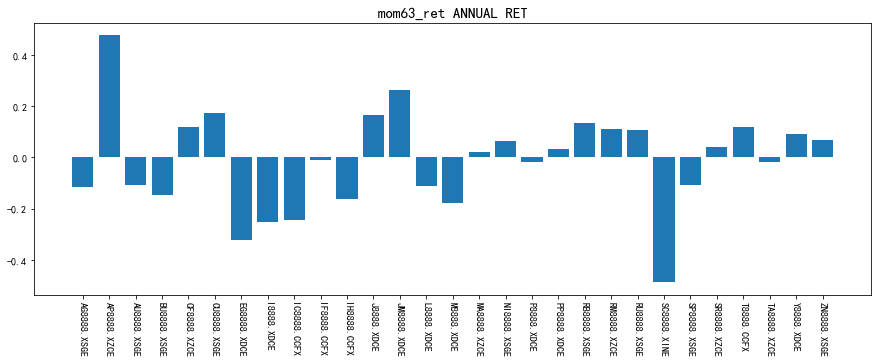

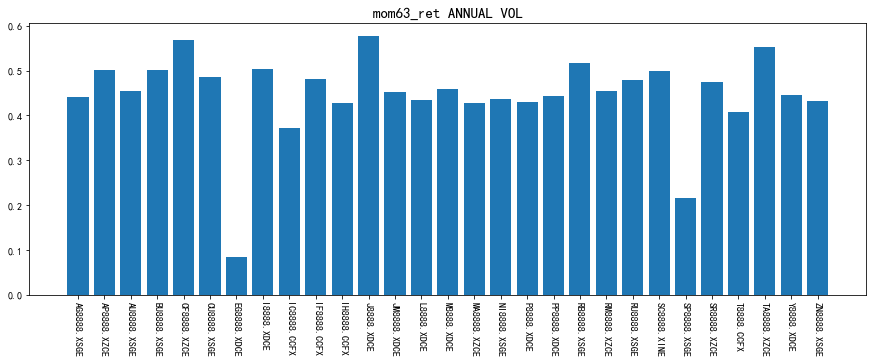

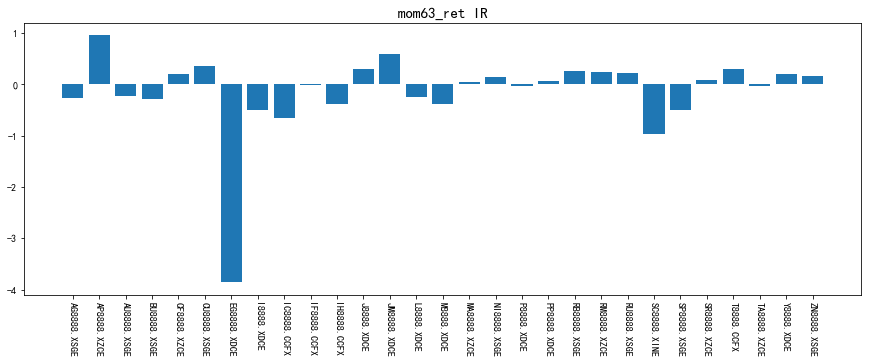

             mean_IR
mom21_ret   0.095313
mom63_ret  -0.146721
mom126_ret -0.187243


In [987]:
# for col in mainfutures_M_AllmomE_annualRet.columns:
for col in ['mom63_ret']:
    plt.figure(figsize=(15,5))
    plt.bar(mainfutures_M_AllmomE_annualRet.index,mainfutures_M_AllmomE_annualRet[col])
    plt.xticks(rotation=-90)
    plt.title('%s ANNUAL RET'%(col),fontsize=15)
    plt.show()
# for col in mainfutures_M_AllmomE_annualVol.columns:
for col in ['mom63_ret']:
    plt.figure(figsize=(15,5))
    plt.bar(mainfutures_M_AllmomE_annualVol.index,mainfutures_M_AllmomE_annualVol[col])
    plt.xticks(rotation=-90)
    plt.title('%s ANNUAL VOL'%(col),fontsize=15)
    plt.show()
# for col in mainfutures_M_AllmomE_annualVol.columns:
for col in ['mom63_ret']:
    plt.figure(figsize=(15,5))
    plt.bar(mainfutures_M_AllmomE_annualVol.index,(mainfutures_M_AllmomE_annualRet/mainfutures_M_AllmomE_annualVol)[col])
    plt.xticks(rotation=-90)
    plt.title('%s IR'%(col),fontsize=15)
    plt.show()
print((mainfutures_M_AllmomE_annualRet/mainfutures_M_AllmomE_annualVol).mean().to_frame('mean_IR'))

总体来讲，63日为窗口（动量以及指数加权已实现波动）的评价指标较为缓和，年化波动指标在设定目标0.04附近波动

## 各品种风险平价后再等权组合策略表现分析

In [988]:
col = 'mom21_ret'
Trend=pd.DataFrame()
for col in ['mom21_ret','mom63_ret','mom126_ret',]:
    Trend_tmp=((mainfutures_M_AllmomR_.pivot_table(index='date',columns='class',values=col).mean(axis=1).shift(1).fillna(0)+1).cumprod()).to_frame(col)
    Trend=pd.concat([Trend,Trend_tmp],axis=1)

                  IR  annual_ret  annual_vol
mom21_ret   0.745167    0.167721    0.225079
mom63_ret   0.733173    0.157269    0.214505
mom126_ret  0.488577    0.106866    0.218729


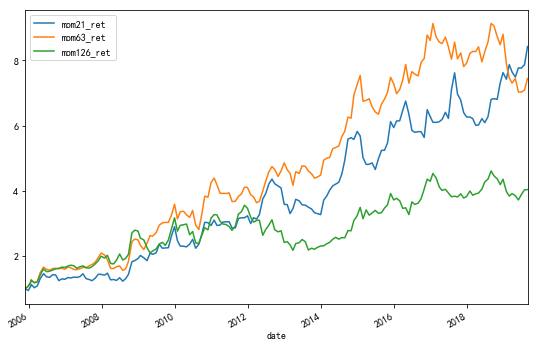

In [991]:
# 报告IR
annual_ret=((Trend.iloc[-1,:]/Trend.iloc[0,:])**(365.25/(Trend.index[-1]-Trend.index[0]).days)-1)#.to_frame('annual_ret')
annual_vol=(Trend.pct_change().dropna().std()*12**0.5)#.to_frame('annual_vol')
print(pd.concat([(annual_ret/annual_vol).to_frame('IR'),annual_ret.to_frame('annual_ret'),annual_vol.to_frame('annual_vol')],axis=1))
# 净值曲线
Trend.plot(figsize=(9,6))
plt.show()

风险平价后的各品种策略相关性较小，直接等权组合后的IR提升较高  
整体而言对期货多品种策略结合提供了思路，期货的多品种不同于多股票，**不同品种的收益特征区别较大**，更像在进行资产配置，因此对小波动品种适当增加杠杆是很必要的。  
（朴素）风险平价的奥秘就在于杠杆，没有杠杆的风险平价只能创造很低的收益（因为承担了很低的风险）；风险平价近似最大化夏普比率，因此承担单位风险获取的超额收益是相对较高的，在允许杠杆的情况下设定目标波动（$\sigma_t^{tgt}$），可以取得很客观的收益，并使得风险平价策略与其他策略（比如基准）具有可比性。

## 趋势跟踪业绩归因分析
趋势跟踪策略在单品种上的表现不尽如人意，可以将之视作很多CTA基金；将所有运用目标波动朴素风险平价的策略简单等权组合后能够取得较好的收益，可以将之视作FOF。  
多品种组合策略的业绩提升在于分散化的威力，这是相对于单品种策略而言的。  
多品种策略近年来（或者历史上）的失效却未必是由于分散化威力的降低。

**多品种趋势跟踪 = 组合+趋势跟踪策略=分散化+行情**

### 多品种趋势跟踪效果与资产相关性

In [999]:
def ComputeRet(df):
    df_=df.sort_values('date').copy()
    df_['ret']=df_['close']/df_['close'].shift(1)-1
    return df_
mainfutures_reason = mainfutures_TradeData_df_.groupby('class').apply(ComputeRet).reset_index(drop=True)

In [1006]:
corrW=90
mainfutures_corr=mainfutures_reason.pivot(columns='class',values='ret',index='date').rolling(corrW).corr()

In [1050]:
def ComputeMeanCorr(df):
    df_=df.copy()
    df_d=df_.dropna(how='all',axis=1).dropna(how='all',axis=0)
    corr_coef=(df_d.sum().sum()-len(df_d))/((len(df_d)**2-len(df_d)))
    return corr_coef
MeanCorr=mainfutures_corr.groupby('date').apply(ComputeMeanCorr).dropna().to_frame('MeanCorr')

F:\Anaconda\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in double_scalars
  after removing the cwd from sys.path.


In [1069]:
MeanCorr_=MeanCorr.copy()
MeanCorr_['date']=MeanCorr_.index
MeanCorr_M=MeanCorr_.apply(lambda x:x.resample('M').last()).reset_index(drop=True).set_index('date')
MeanCorrE_M=MeanCorr_M.merge(Trend,on=['date'],how='left').dropna()
MeanCorrE_M['MeanCorr']=MeanCorrE_M['MeanCorr']*10

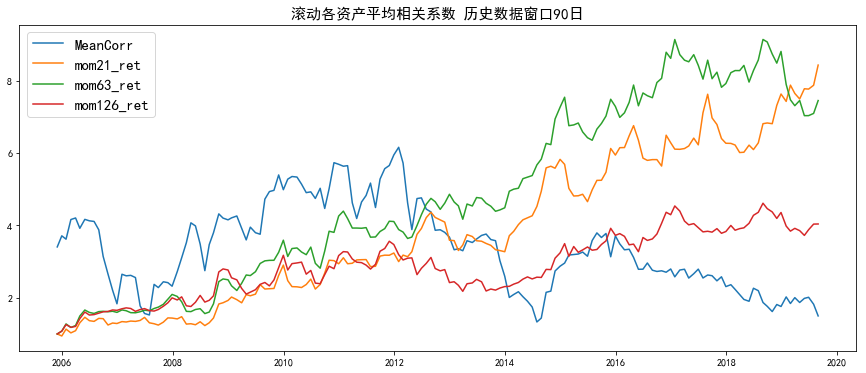

In [1076]:
plt.figure(figsize=(15,6))
for col in MeanCorrE_M.columns:
    plt.plot(MeanCorrE_M[col],label=col)
plt.title('滚动各资产平均相关系数 历史数据窗口%d日'%(corrW),fontsize=15)
plt.legend(loc=0,fontsize=15)
plt.show()

可以得到结论：多品种趋势跟踪策略的失效与分散化效果降低无关，在品种间相关性上升时策略的收益依然能够上升，最近3年资产间的相关性保持下降理应有更好的分散化效果但策略净值并未明显上升。  
**多品种趋势跟踪策略的业绩原因与分散化程度没有明显的关系，不能被“资产间相关性下降，分散效果好，多品种组合收益更高”的理论解释**

### 各行情下多品种趋势跟踪策略业绩
（平均收益的绝对值，数值越大说明越存在行情-上涨或下跌行情）

In [1080]:
# 计算月度收益用于结算
def ComputeNextRet(df):
    df_=df.copy().sort_values('date')
    df_['ret']=(df_['close']/df_['close'].shift(1)-1)
    return df_
mainfutures_R = mainfutures_M_Allmom.groupby('class').apply(ComputeNextRet).reset_index(drop=True)

In [1113]:
# 获取季度数据
mainfutures_Q = mainfutures_M_Allmom.set_index('date').groupby('class').apply(lambda x: x.resample('Q').last())
mainfutures_Q.index=mainfutures_Q.index.droplevel(0)
mainfutures_Q=mainfutures_Q.reset_index()
Trend_Q=Trend.apply(lambda x: x.resample('Q').last())

In [1115]:
# 计算季度收益率
mainfutures_QR = mainfutures_Q.groupby('class').apply(ComputeNextRet).reset_index(drop=True)

In [1116]:
# 使用风险调整后收益，使不同品种间收益率具有可加性
mainfutures_QR['adj_ret']=mainfutures_QR['ret']/mainfutures_QR['sigmaY21']

In [1133]:
# 计算多品种持有到期风险调整收益的平均值 & 策略收益
mainfutures_absavgR=mainfutures_QR.pivot_table(index='date',values='adj_ret',columns='class').abs().mean(axis=1).to_frame('abs_avgret')
Trend_QR=Trend_Q.pct_change().dropna().merge(mainfutures_absavgR,on=['date'],how='left')

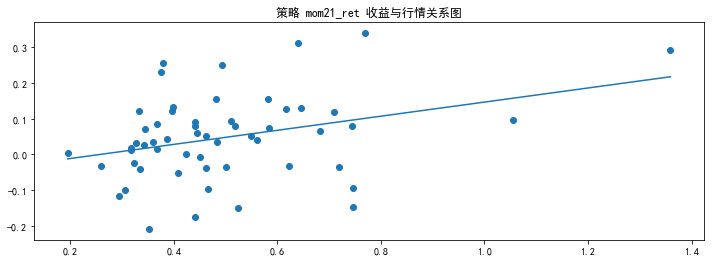

                            OLS Regression Results                            
Dep. Variable:              mom21_ret   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     6.654
Date:                Tue, 10 Sep 2019   Prob (F-statistic):             0.0127
Time:                        23:00:09   Log-Likelihood:                 43.507
No. Observations:                  55   AIC:                            -83.01
Df Residuals:                      53   BIC:                            -79.00
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0507      0.041     -1.243      0.2

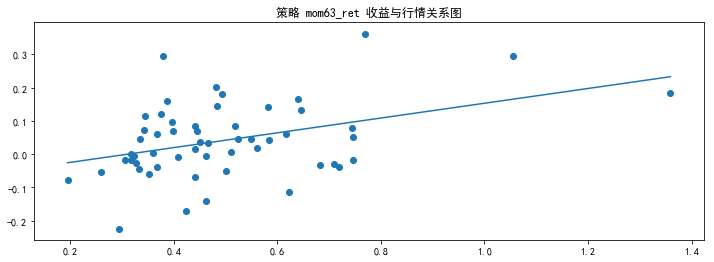

                            OLS Regression Results                            
Dep. Variable:              mom63_ret   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     10.13
Date:                Tue, 10 Sep 2019   Prob (F-statistic):            0.00245
Time:                        23:00:10   Log-Likelihood:                 48.339
No. Observations:                  55   AIC:                            -92.68
Df Residuals:                      53   BIC:                            -88.66
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0690      0.037     -1.847      0.0

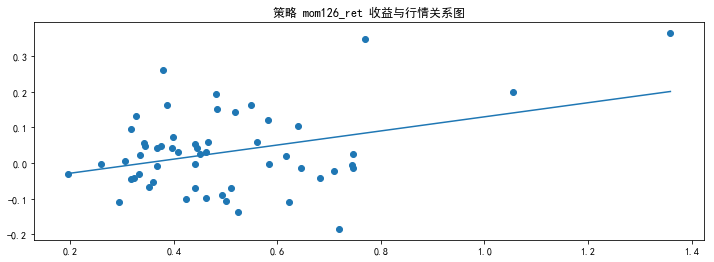

                            OLS Regression Results                            
Dep. Variable:             mom126_ret   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.109
Method:                 Least Squares   F-statistic:                     7.615
Date:                Tue, 10 Sep 2019   Prob (F-statistic):            0.00793
Time:                        23:00:10   Log-Likelihood:                 46.873
No. Observations:                  55   AIC:                            -89.75
Df Residuals:                      53   BIC:                            -85.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0684      0.038     -1.783      0.0

In [1148]:
for col in [col for col in Trend_QR.columns if col not in ['abs_avgret']]:
    result=sm.OLS(Trend_QR[col],sm.add_constant(Trend_QR['abs_avgret'])).fit()
    x=[Trend_QR['abs_avgret'].min(),Trend_QR['abs_avgret'].max()]
    y_hat=[result.params['const']+result.params['abs_avgret']*x for x in [Trend_QR['abs_avgret'].min(),Trend_QR['abs_avgret'].max()]]
    plt.figure(figsize=(12,4))
    plt.plot(x,y_hat)
    plt.title('策略 %s 收益与行情关系图'%(col))
    plt.scatter(Trend_QR['abs_avgret'],Trend_QR[col])
    plt.show()
    print(result.summary())

季度行情（所有单品种持有到期收益经风险调整后取平均值再取绝对值）与策略收益的散点关系图。  
得益于一些极端值，策略收益与行情的关系是显著正向的，进一步说明在极端行情下多品种趋势跟踪策略可以取得优异业绩。

## 关于时间序列动量的一些评论

并不是所有人都是趋势跟踪的拥趸。
Kim, Tse, and Wald (2016) 对时间序列动量了进行反思，发现时间序列动量**只有使用波动率调整时（放杠杆）时才会优于买入持有和横截面动量策略，没有进行波动率调整的时间序列动量和买入持有策略没有显著差异**，进行波动率调整的买入持有策略和进行波动率调整的时间序列动量也没有明显差异。因此得出结论，时间序列动量之所以有效，是因为使用了**杠杆**。
Huang et al. (2019) 也对时间序列动量进行了一顿猛轰 。首先，对每个品种，以过去 12 个月收益率为自变量，未来 1 个月收益率为因变量，进行回归分析，55 个品种中有 47 个 t 统计量小于 1.65，表明过去收益率的预测能力有限。其次，他们做了 Moskowitz et al. (2012) 相似的面板回归，确实获得了较高的 t 统计量，由于没有控制固定效应等因素，该面板回归可能误差很大。最后，由于波动率加权也会带来收益贡献，因此构造了等权重 TSMOM 组合；与此同时，构造了不需要收益率预测的 TSH 策略，根据品种历史平均收益符号来决定交易方向；测试表明，等权重的 TSMOM 和 TSH 并没有显著的不同，因此得出结论，TSMOM 可能是由于品种之间历史收益不同引起的。基于以上分析，Huang et al. (2019) 对**时间序列动量的真实存在性进行了严重怀疑**。